# Задача 9. Hand-crafted graph features

* **Дедлайн**: 16.05.2025, 23:59
* Основной полный балл: 5
* Максимум баллов: 10


## Задача

- [ ] Найти или сгенерировать набор данных для бинарной классификации графов.
- [ ] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [ ] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [ ] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [73]:
random.seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)

### Генерация графов

In [65]:
def generate_graph_with_bridge(max_n_nodes=30, p=0.5):
    if rng.random() < p:
        bridge_len = rng.integers(0, 3)
        n = rng.integers(2, (max_n_nodes - bridge_len) // 2)
        G = nx.barbell_graph(n, bridge_len)
    else:
        G = nx.path_graph(rng.integers(5, max_n_nodes))
    return G


def generate_graph_without_bridge(max_n_nodes=30, p=0.5):
    if rng.random() < p:
        G = nx.complete_graph(rng.integers(5, max_n_nodes))
    else:
        n = rng.integers(6, max_n_nodes - 3)
        G = nx.cycle_graph(n)

        num_extra_edges = rng.integers(2, min(n // 2, max_n_nodes - n))
        for _ in range(num_extra_edges):
            u, v = rng.choice(n, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v)
    return G


def generate_dataset(n_samples=100, max_n_nodes=10, p=0.5):
    graphs = []
    labels = []
    for _ in range(n_samples // 2):
        G_with = generate_graph_with_bridge(max_n_nodes, p)
        G_without = generate_graph_without_bridge(max_n_nodes, p)
        graphs.append(G_with)
        labels.append(1)
        graphs.append(G_without)
        labels.append(0)
    return graphs, labels

In [74]:
graphs, labels = generate_dataset(n_samples=2000, max_n_nodes=30, p=0.4)
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.25, random_state=42, stratify=labels)

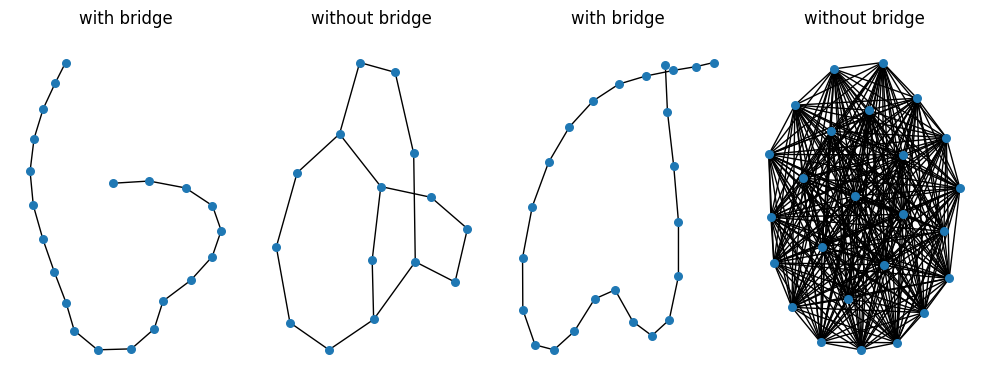

In [75]:
def visualize(graphs, labels):
    plt.figure(figsize=(10, 4))
    for i, G in enumerate(graphs[:4]):
        plt.subplot(1, 4, i + 1)
        nx.draw(G, node_size=30, with_labels=False)
        plt.title(("with" if labels[i] else "without") + " bridge")
    plt.tight_layout()
    plt.show()


visualize(graphs, labels)

### Shortest-Path Kernel

In [76]:
def graph_to_sp_vector(G, max_path_len=None):
    sp_lengths = dict(nx.shortest_path_length(G))
    counter = Counter()

    for source in sp_lengths:
        for target in sp_lengths[source]:
            if source < target:
                length = sp_lengths[source][target]
                counter[length] += 1

    if max_path_len is None:
        max_path_len = max(counter.keys(), default=0)

    vec = np.zeros(max_path_len + 1)
    for length, count in counter.items():
        vec[length] = count

    return vec


def shortest_path_kernel(train_graphs, test_graphs):
    all_graphs = train_graphs + test_graphs
    all_vectors = [graph_to_sp_vector(G) for G in all_graphs]

    max_len = max(len(v) for v in all_vectors)
    all_vectors = [np.pad(v, (0, max_len - len(v))) for v in all_vectors]

    train_vecs = np.stack(all_vectors[:len(train_graphs)])
    test_vecs = np.stack(all_vectors[len(train_graphs):])

    K_train = train_vecs @ train_vecs.T
    K_test = test_vecs @ train_vecs.T

    return K_train, K_test

### Обучение с Shortest-Path Kernel

In [79]:
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)

parameters = {'C': [0.001, 0.1, 10, 100]}
svc = SVC(kernel='precomputed', random_state=42)
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(K_train, train_labels)

print("Best:", clf.best_params_)
pred_labels = clf.predict(K_test)
print("Classification report:\n", classification_report(test_labels, pred_labels, digits=3))
print("Confusion matrix:\n", confusion_matrix(test_labels, pred_labels))

Best: {'C': 10}
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.864     0.927       250
           1      0.880     1.000     0.936       250

    accuracy                          0.932       500
   macro avg      0.940     0.932     0.932       500
weighted avg      0.940     0.932     0.932       500

Confusion matrix:
 [[216  34]
 [  0 250]]


### Weisfeiler-Lehman Kernel

In [77]:
def wl_features(G, h=3):
    labels = {node: str(G.degree[node]) for node in G.nodes}
    feature_counts = Counter(labels.values())

    for i in range(h):
        new_labels = {}
        for node in G.nodes:
            neighborhood = sorted([labels[neighbor] for neighbor in G.neighbors(node)])
            new_label = labels[node] + "_" + "_".join(neighborhood)
            new_labels[node] = new_label

        compressed_labels = {node: str(hash(label)) for node, label in new_labels.items()}
        labels = compressed_labels
        feature_counts.update(labels.values())

    return feature_counts


def wl_kernel_features(graphs, h=3):
    histograms = [wl_features(G, h) for G in graphs]
    all_labels = sorted(set(label for hist in histograms for label in hist))
    label_idx = {label: i for i, label in enumerate(all_labels)}

    vectors = np.zeros((len(graphs), len(all_labels)))
    for i, hist in enumerate(histograms):
        for label, count in hist.items():
            vectors[i, label_idx[label]] = count

    return vectors


def wl_feature_histograms(graphs, h=3):
    histograms = [wl_features(G, h) for G in graphs]
    label_set = set(label for hist in histograms for label in hist)
    return histograms, label_set


def vectorize_histograms(histograms, label_vocab):
    label_idx = {label: i for i, label in enumerate(sorted(label_vocab))}
    vecs = np.zeros((len(histograms), len(label_vocab)))
    for i, hist in enumerate(histograms):
        for label, count in hist.items():
            if label in label_idx:
                vecs[i, label_idx[label]] = count
    return vecs


def wl_kernel(train_graphs, test_graphs, h=3):
    train_hists, train_labels = wl_feature_histograms(train_graphs, h)
    test_hists, test_labels = wl_feature_histograms(test_graphs, h)

    all_labels = train_labels.union(test_labels)

    train_vecs = vectorize_histograms(train_hists, all_labels)
    test_vecs = vectorize_histograms(test_hists, all_labels)

    K_train = train_vecs @ train_vecs.T
    K_test = test_vecs @ train_vecs.T
    return K_train, K_test

### Обучение с Weisfeiler-Lehman Kernel

In [78]:
K_train, K_test = wl_kernel(train_graphs, test_graphs, h=3)

parameters = {'C': [0.001, 0.1, 10, 100]}
svc = SVC(kernel='precomputed', random_state=42)
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(K_train, train_labels)

print("Best:", clf.best_params_)
pred_labels = clf.predict(K_test)
print("Classification report:\n", classification_report(test_labels, pred_labels, digits=3))
print("Confusion matrix:\n", confusion_matrix(test_labels, pred_labels))

Best: {'C': 0.1}
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.996     0.998       250
           1      0.996     1.000     0.998       250

    accuracy                          0.998       500
   macro avg      0.998     0.998     0.998       500
weighted avg      0.998     0.998     0.998       500

Confusion matrix:
 [[249   1]
 [  0 250]]


### Выводы
Метрики на задаче бинарной классификации демонстрируют высокую эффективность обоих ядер, однако WL Kernel стабильно превосходит Shortest-Path Kernel как по качеству, так и по времени вычислений.
WL Kernel достиг почти идеального качества на тестовой выборке (F1-score 0.998 против 0.932 у SP Kernel) и при этом оказался значительно быстрее — менее 1 секунды против 1 минуты 20 секунд для SP.
